<a href="https://colab.research.google.com/github/cesaraugustopereirabr/Reconhecimento_Facial/blob/main/reconhecimento_facial_brics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⬆️ Envie várias imagens de referência (ex: lula_1.jpg, xi_jinping_1.jpg...)


Saving cyrilramaphosa_1.jpg to cyrilramaphosa_1.jpg
Saving cyrilramaphosa_2.jpg to cyrilramaphosa_2.jpg
Saving cyrilramaphosa_3.jpg to cyrilramaphosa_3.jpg
Saving cyrilramaphosa_4.jpeg to cyrilramaphosa_4.jpeg
Saving Lula_1.jpg to Lula_1.jpg
Saving lula_2.jpeg to lula_2.jpeg
Saving Narendra Modi_1.jpg to Narendra Modi_1.jpg
Saving Narendra Modi_2.jpg to Narendra Modi_2.jpg
Saving Narendra Modi_3.jpg to Narendra Modi_3.jpg
Saving Narendra Modi_4.jpg to Narendra Modi_4.jpg
Saving Sergei Lavrov_1.jpg to Sergei Lavrov_1.jpg
Saving XI Jinping_1.jpg to XI Jinping_1.jpg
Saving XI Jinping_2.jpg to XI Jinping_2.jpg

✅ Criando banco de dados com embeddings (ArcFace + cosine)...
✅ cyrilramaphosa_1.jpg processado como 'cyrilramaphosa'
✅ lula2.jpeg processado como 'lula2'
✅ Narendra Modi_4.jpg processado como 'Narendra Modi'
✅ Narendra Modi_2.jpg processado como 'Narendra Modi'
✅ Sergei Lavrov_1.jpg processado como 'Sergei Lavrov'
✅ Lula_1.jpg processado como 'Lula'
✅ Lula1.jpg processado como 'Lul

Saving Brics.jpg to Brics (3).jpg

🔍 Iniciando detecção e reconhecimento facial...


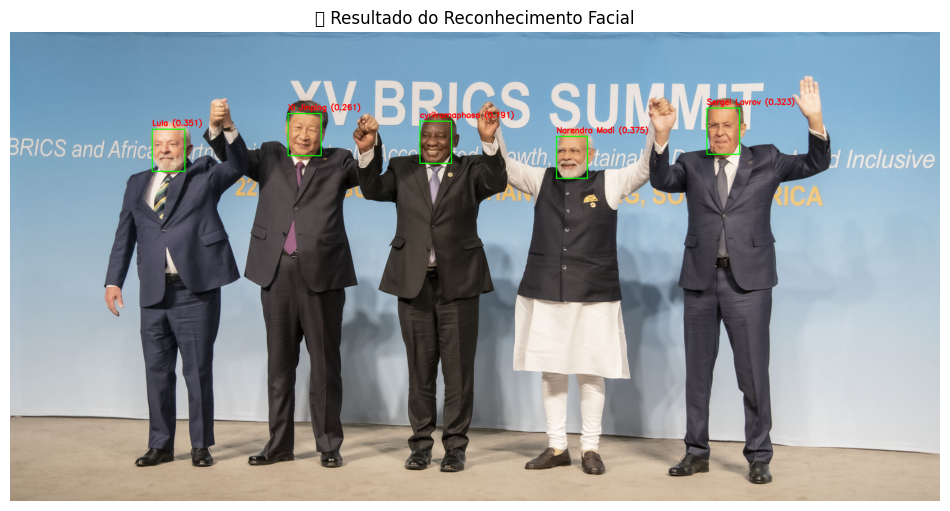

In [ ]:
# Instalar bibliotecas necessárias
!pip install deepface opencv-python-headless --quiet

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from google.colab import files
from PIL import Image
from collections import defaultdict

# -----------------------------
# 1. Upload das imagens de referência
# -----------------------------
os.makedirs("faces_referencia", exist_ok=True)
print("⬆️ Envie várias imagens de referência (ex: lula_1.jpg, xi_jinping_1.jpg...)")
uploaded = files.upload()

for filename in uploaded.keys():
    os.rename(filename, f"faces_referencia/{filename}")

# -----------------------------
# 2. Criar base de embeddings
# -----------------------------
print("\n✅ Criando banco de dados com embeddings (ArcFace + cosine)...")
face_db = defaultdict(list)
model_name = "ArcFace"

def extract_name(filename):
    base = os.path.splitext(filename)[0]
    # Se terminar com número, remove só esse número
    parts = base.split("_")
    if parts[-1].isdigit():
        return "_".join(parts[:-1])
    return base

for filename in os.listdir("faces_referencia"):
    name = extract_name(filename)  # ✔️ Agora não perde nomes
    img_path = os.path.join("faces_referencia", filename)

    try:
        embedding_obj = DeepFace.represent(
            img_path=img_path,
            model_name=model_name,
            enforce_detection=True
        )[0]

        face_db[name].append(embedding_obj["embedding"])
        print(f"✅ {filename} processado como '{name}'")

    except Exception as e:
        print(f"⚠️ Erro ao processar {filename}: {e}")

# -----------------------------
# 3. Upload da imagem principal
# -----------------------------
print("\n⬆️ Agora envie a imagem com várias pessoas para reconhecimento:")
uploaded_test = files.upload()
test_img_path = list(uploaded_test.keys())[0]

# -----------------------------
# 4. Reconhecimento facial
# -----------------------------
print("\n🔍 Iniciando detecção e reconhecimento facial...")
img_bgr = cv2.imread(test_img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Detector melhor (retinaface)
detections = DeepFace.extract_faces(
    img_path=test_img_path,
    detector_backend='retinaface',
    enforce_detection=False
)

# Threshold apropriado para cosine + ArcFace
threshold = 0.40

def cosine_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

for i, face_info in enumerate(detections):
    facial_area = face_info['facial_area']
    x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

    face_crop = img_rgb[y:y+h, x:x+w]
    temp_face_path = f"face_temp_{i}.jpg"
    Image.fromarray(face_crop).save(temp_face_path)

    try:
        embedding_obj = DeepFace.represent(
            img_path=temp_face_path,
            model_name=model_name,
            enforce_detection=False
        )[0]
        embedding = embedding_obj["embedding"]
    except Exception as e:
        print(f"⚠️ Erro ao gerar embedding para rosto {i}: {e}")
        continue

    best_match = "desconhecido"
    min_dist = float("inf")

    for name, ref_embeddings in face_db.items():
        for ref_embedding in ref_embeddings:
            dist = cosine_distance(embedding, ref_embedding)
            if dist < min_dist:
                min_dist = dist
                best_match = name

    label = best_match if min_dist < threshold else "desconhecido"

    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img_rgb, f"{label} ({min_dist:.3f})", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

# -----------------------------
# Exibição final
# -----------------------------
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("🔎 Resultado do Reconhecimento Facial")
plt.show()